<a href="https://colab.research.google.com/github/daniel-mckemie/data71200_Su24_McKemie/blob/main/DMcKemie_DATA71200_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -U scikit-learn==1.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
import os
import tarfile
from six.moves import urllib
import io

GITHUB_REPO_URL = "https://raw.githubusercontent.com/daniel-mckemie/data71200_Su24_McKemie/main/"
TAR_FILE_NAME = "tmb_mskcc_2018.tar"
DATA_FILE_NAME_PATIENT = "tmb_mskcc_2018/data_clinical_patient.txt"
DATA_FILE_NAME_SAMPLE = "tmb_mskcc_2018/data_clinical_sample.txt"
DATA_FILE_NAME_GENE_PANEL_MATRIX = "tmb_mskcc_2018/data_gene_panel_matrix.txt"
DATA_FILE_NAME_SV = "tmb_mskcc_2018/data_sv.txt"
DATA_FILE_NAME_MUTATIONS = "tmb_mskcc_2018/data_mutations.txt"

WITHOUT_MUTATION_DATA = "without_mutation_data.csv"
WITH_MUTATION_DATA = "with_mutation_data.csv"

DATA_FILES = [
    DATA_FILE_NAME_PATIENT,
    DATA_FILE_NAME_SAMPLE,
    DATA_FILE_NAME_GENE_PANEL_MATRIX,
    DATA_FILE_NAME_SV,
    DATA_FILE_NAME_MUTATIONS,

]


In [4]:
def load_data_from_github(github_url=GITHUB_REPO_URL, tar_file=TAR_FILE_NAME, data_files=DATA_FILES):
    tar_url = github_url + tar_file

    # Download the tar file to a local temporary file
    temp_file, _ = urllib.request.urlretrieve(tar_url)

    try:
        dataframes = {}
        # Open the tar file from the local temporary file
        with tarfile.open(temp_file, mode="r") as data_tar:
            for data_file in data_files:
                # Extract the specific txt file (now with correct path)
                extracted_file = data_tar.extractfile(data_file)
                if extracted_file:
                    # Read the content of the extracted file
                    file_content = extracted_file.read()
                    # Decode the content (assuming it's encoded in 'utf-8')
                    decoded_content = file_content.decode('utf-8')
                    # Create a StringIO object from the decoded content
                    string_io = io.StringIO(decoded_content)
                    df = pd.read_csv(string_io, sep=None, engine='python', skiprows=0)
                    if data_file in [DATA_FILE_NAME_PATIENT, DATA_FILE_NAME_SAMPLE]:
                        df = pd.read_csv(io.StringIO(decoded_content), sep=None, engine='python', skiprows=4)
                    dataframes[data_file] = df
                else:
                    print(f"File '{data_file}' not found in the tar archive.")
                    return None
        return dataframes
    finally:
        # Remove the temporary file to clean up
        os.remove(temp_file)


In [5]:
# QUESTION: What are correlations between mutation data and mortality and cancer type (possibly)?

# Load the data
dataframes = load_data_from_github()

# Check if dataframes were loaded
if dataframes:
    df_patient = dataframes.get(DATA_FILE_NAME_PATIENT)
    df_patient.columns = df_patient.columns.str.upper() # Capitalize Column Names

    df_sample = dataframes.get(DATA_FILE_NAME_SAMPLE)
    df_sample.columns = df_sample.columns.str.upper()

    df_gene_panel_matrix = dataframes.get(DATA_FILE_NAME_GENE_PANEL_MATRIX)
    df_gene_panel_matrix.columns = df_gene_panel_matrix.columns.str.upper()

    df_sv = dataframes.get(DATA_FILE_NAME_SV)
    df_sv.columns = df_sv.columns.str.upper()

    df_mutations = dataframes.get(DATA_FILE_NAME_MUTATIONS)
    df_mutations.columns = df_mutations.columns.str.upper()



    # Join tables
    merged_df = pd.merge(df_patient, df_sample, on="PATIENT_ID")
    merged_df = pd.merge(merged_df, df_gene_panel_matrix, on="SAMPLE_ID")

    # Left join to keep all patients
    # Right join to only keep patients who have gene/sample info
    merged_df = pd.merge(merged_df, df_sv, on="SAMPLE_ID", how="left")

    # A few dozen duplicates, arguably not needed.  Prune...
    merged_df.drop_duplicates(subset=['PATIENT_ID'], inplace=True)

    # Change variable name for clarity
    without_mutation_df = merged_df

    print('Success')


else:
    print("Cannot merge dataframes as one or both are missing.")



Success


In [6]:
# Save the merged DataFrame to a CSV file
without_mutation_df.to_csv(WITHOUT_MUTATION_DATA, index=False)

# Full data of mutations, perhaps for later use...
with_mutation_df = pd.merge(merged_df, df_mutations, left_on="SAMPLE_ID", right_on="TUMOR_SAMPLE_BARCODE", how="left")
with_mutation_df.to_csv(WITH_MUTATION_DATA, index=False)

In [7]:
# Show some info
print(without_mutation_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1661 entries, 0 to 1718
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PATIENT_ID                   1661 non-null   object 
 1   SEX                          1661 non-null   object 
 2   OS_MONTHS                    1661 non-null   int64  
 3   OS_STATUS                    1661 non-null   object 
 4   AGE_GROUP                    1661 non-null   object 
 5   DRUG_TYPE                    1661 non-null   object 
 6   SAMPLE_ID                    1661 non-null   object 
 7   CANCER_TYPE                  1661 non-null   object 
 8   SAMPLE_TYPE                  1661 non-null   object 
 9   SAMPLE_CLASS                 1661 non-null   object 
 10  METASTATIC_SITE              1661 non-null   object 
 11  PRIMARY_SITE                 1661 non-null   object 
 12  CANCER_TYPE_DETAILED         1661 non-null   object 
 13  GENE_PANEL             

In [8]:
# Describe!
print(without_mutation_df.describe())

         OS_MONTHS  SAMPLE_COVERAGE  AGE_AT_SEQ_REPORT  TMB_NONSYNONYMOUS  \
count  1661.000000      1661.000000        1660.000000        1661.000000   
mean     14.078266       736.100542          61.411446          11.562370   
std      12.856760       242.746318          13.677945          18.369198   
min       0.000000        56.000000          15.000000           0.000000   
25%       4.000000       581.000000          53.000000           2.936159   
50%      11.000000       744.000000          63.000000           5.872318   
75%      20.000000       891.000000          71.000000          11.091553   
max      80.000000      1744.000000          90.000000         207.488576   

       SITE1_REGION_NUMBER  SITE1_POSITION  SITE2_REGION_NUMBER  \
count            81.000000    2.880000e+02            77.000000   
mean             11.864198    6.049872e+07            13.376623   
std              11.816041    4.992665e+07            11.470831   
min               1.000000    1.215405

In [9]:
y = without_mutation_df['OS_STATUS']
print(y)

0       1:DECEASED
1       1:DECEASED
2         0:LIVING
3         0:LIVING
4         0:LIVING
           ...    
1714      0:LIVING
1715      0:LIVING
1716      0:LIVING
1717      0:LIVING
1718      0:LIVING
Name: OS_STATUS, Length: 1661, dtype: object


In [15]:
# Drop useless columns
X = without_mutation_df.drop(['ANNOTATION', 'COMMENTS', 'EVENT_INFO','NCBI_BUILD', 'BREAKPOINT_TYPE', 'SV_VARIANTID',
                              'SV_STATUS', 'SITE1_REGION', 'SITE1_REGION_NUMBER', 'SITE1_CHROMOSOME', 'SITE1_POSITION',
                              'SITE1_DESCRIPTION', 'SITE2_HUGO_SYMBOL', 'SITE2_REGION', 'SITE2_REGION_NUMBER', 'SITE2_CHROMOSOME',
                              'SITE2_POSITION', 'SITE2_DESCRIPTION', 'SITE2_EFFECT_ON_FRAME'], axis=1)

In [16]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1661 entries, 0 to 1718
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PATIENT_ID                   1661 non-null   object 
 1   SEX                          1661 non-null   object 
 2   OS_MONTHS                    1661 non-null   int64  
 3   OS_STATUS                    1661 non-null   object 
 4   AGE_GROUP                    1661 non-null   object 
 5   DRUG_TYPE                    1661 non-null   object 
 6   SAMPLE_ID                    1661 non-null   object 
 7   CANCER_TYPE                  1661 non-null   object 
 8   SAMPLE_TYPE                  1661 non-null   object 
 9   SAMPLE_CLASS                 1661 non-null   object 
 10  METASTATIC_SITE              1661 non-null   object 
 11  PRIMARY_SITE                 1661 non-null   object 
 12  CANCER_TYPE_DETAILED         1661 non-null   object 
 13  GENE_PANEL             

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Do something with this?
float64_columns = ['NORMAL_READ_COUNT', 'NORMAL_VARIANT_COUNT',
                    'TUMOR_PAIRED_END_READ_COUNT', 'TUMOR_SPLIT_READ_COUNT',
                    'SV_LENGTH', 'TUMOR_READ_COUNT', 'TUMOR_VARIANT_COUNT']


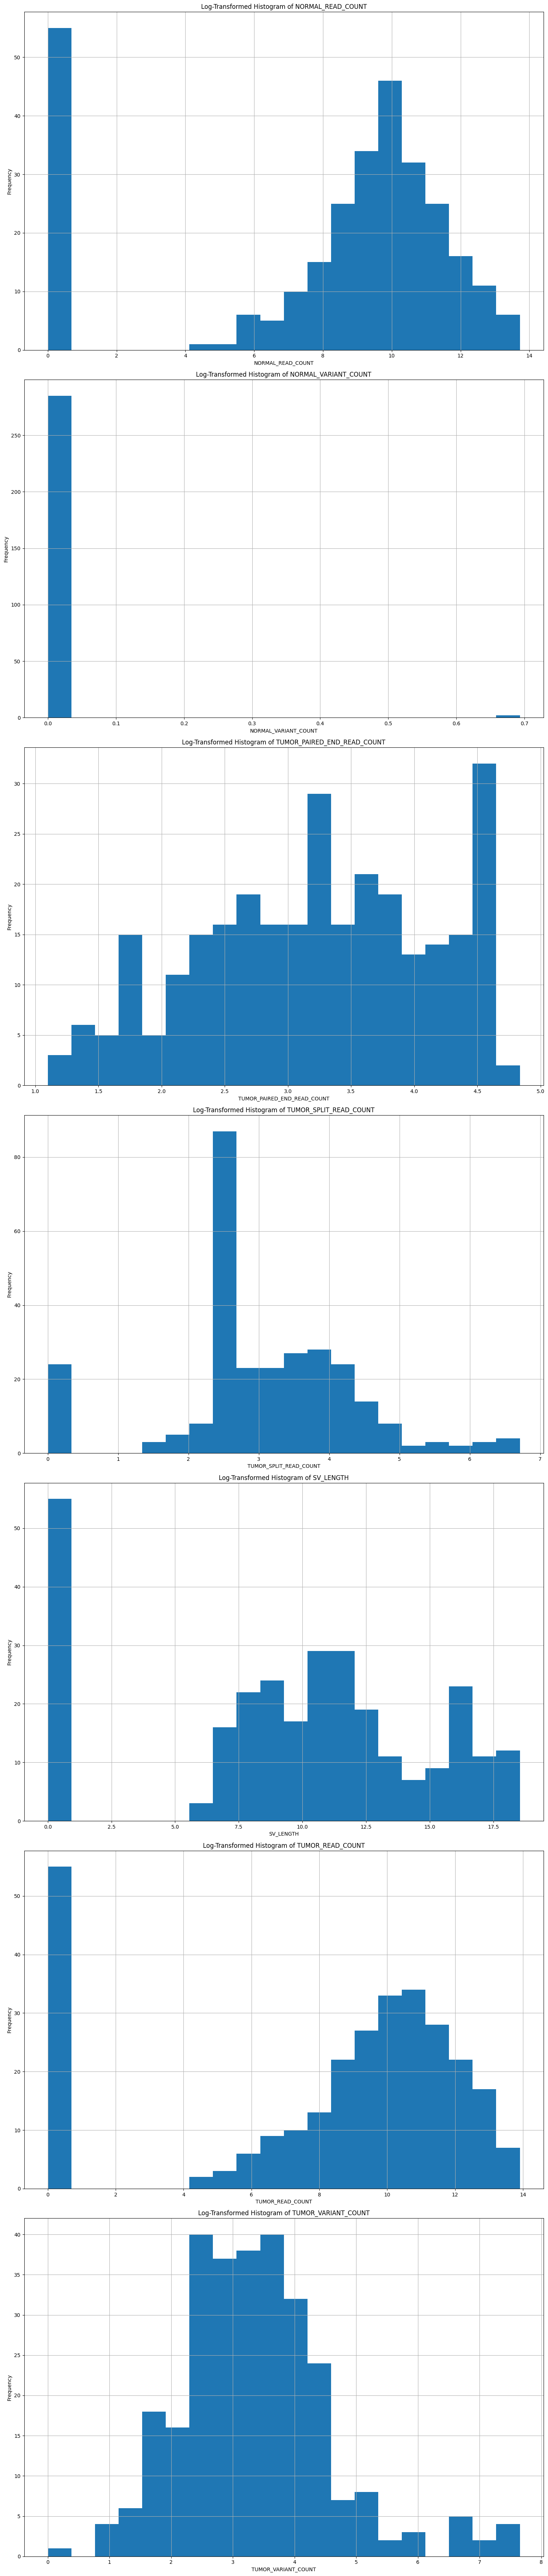

In [19]:
import matplotlib.pyplot as plt

numeric_cols = X[float64_columns].apply(pd.to_numeric, errors='coerce')
numeric_cols_log = numeric_cols.apply(lambda x: np.log1p(x))

fig, axes = plt.subplots(len(numeric_cols_log.columns), 1, figsize=(15, 10*len(numeric_cols_log.columns)))

for ax, col in zip(axes, numeric_cols_log.columns):
    numeric_cols_log[col].hist(bins=20, ax=ax)
    ax.set_title(f'Log-Transformed Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

    # Set scale for x-axis and y-axis if needed
    ax.set_xscale('linear')
    ax.set_yscale('linear')

plt.tight_layout()
plt.show()

<ipython-input-20-972c6fa83f12>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='OS_STATUS', y='OS_MONTHS', data=X, palette='coolwarm', inner='quartile')


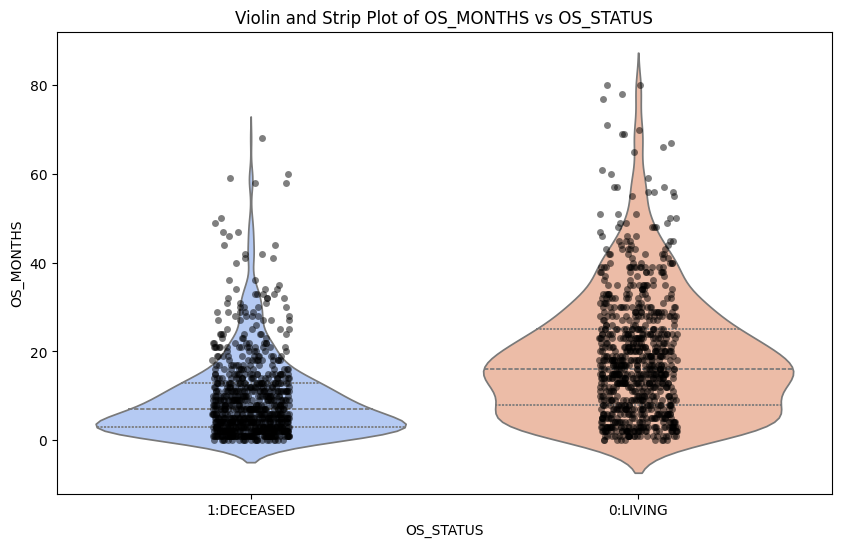

In [20]:
# Strip plot overlaid on violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='OS_STATUS', y='OS_MONTHS', data=X, palette='coolwarm', inner='quartile')
sns.stripplot(x='OS_STATUS', y='OS_MONTHS', data=X, color='k', alpha=0.5)
plt.title('Violin and Strip Plot of OS_MONTHS vs OS_STATUS')
plt.xlabel('OS_STATUS')
plt.ylabel('OS_MONTHS')
plt.show()

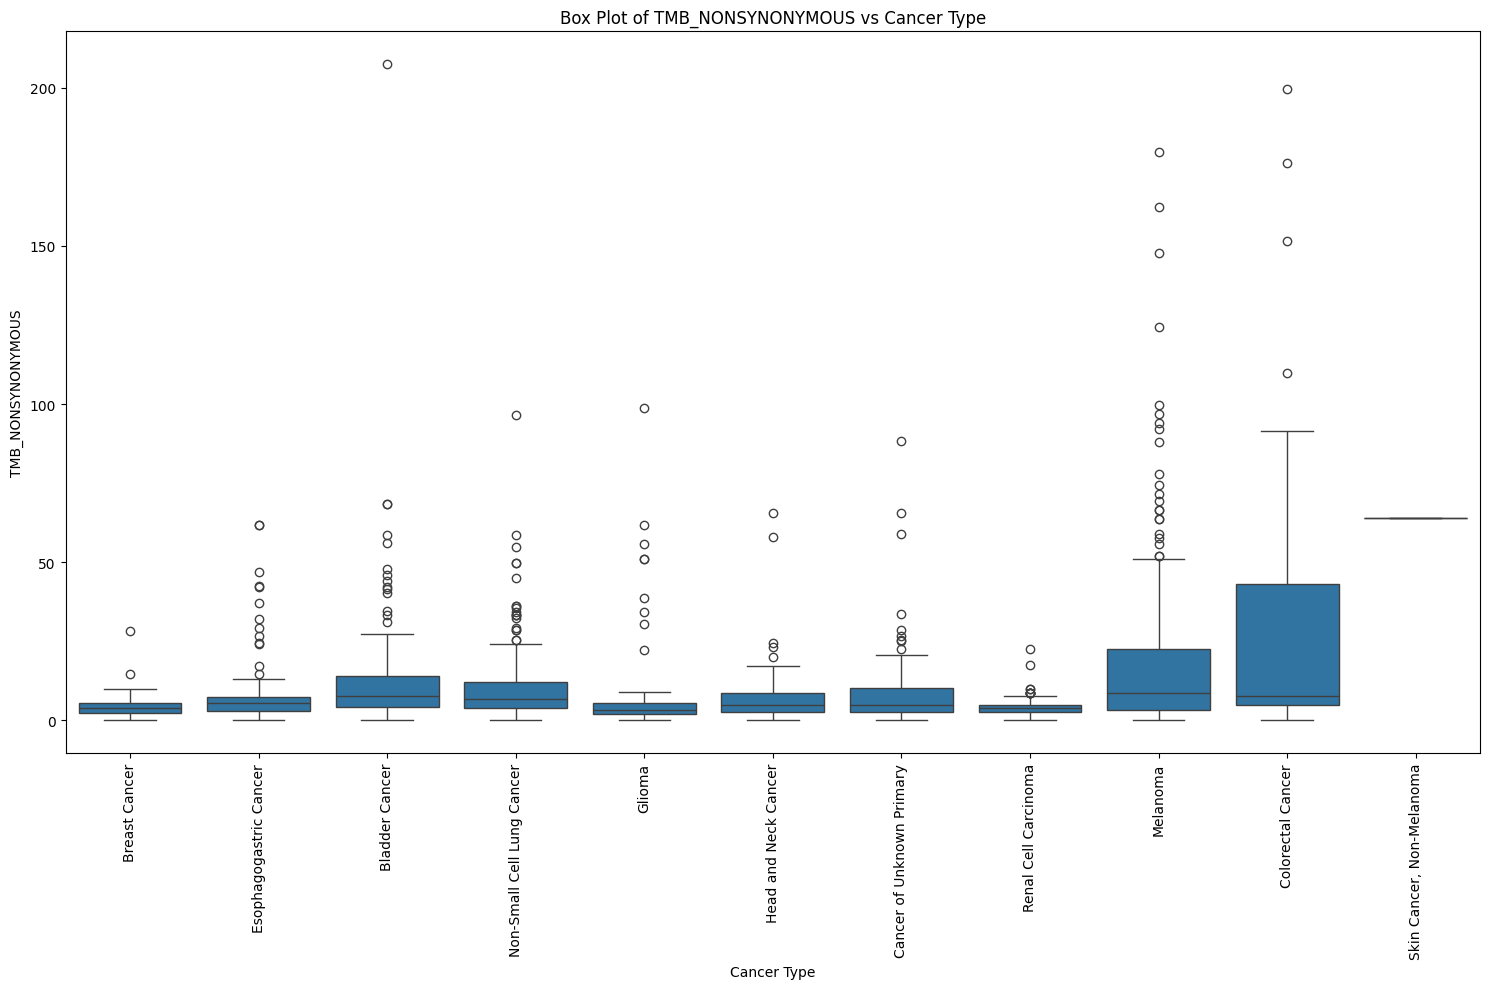

In [21]:
# Plot box plots for numeric data against Cancer Type
plt.figure(figsize=(15, 10))
sns.boxplot(x='CANCER_TYPE', y='TMB_NONSYNONYMOUS', data=X)
plt.title('Box Plot of TMB_NONSYNONYMOUS vs Cancer Type')
plt.xlabel('Cancer Type')
plt.ylabel('TMB_NONSYNONYMOUS')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

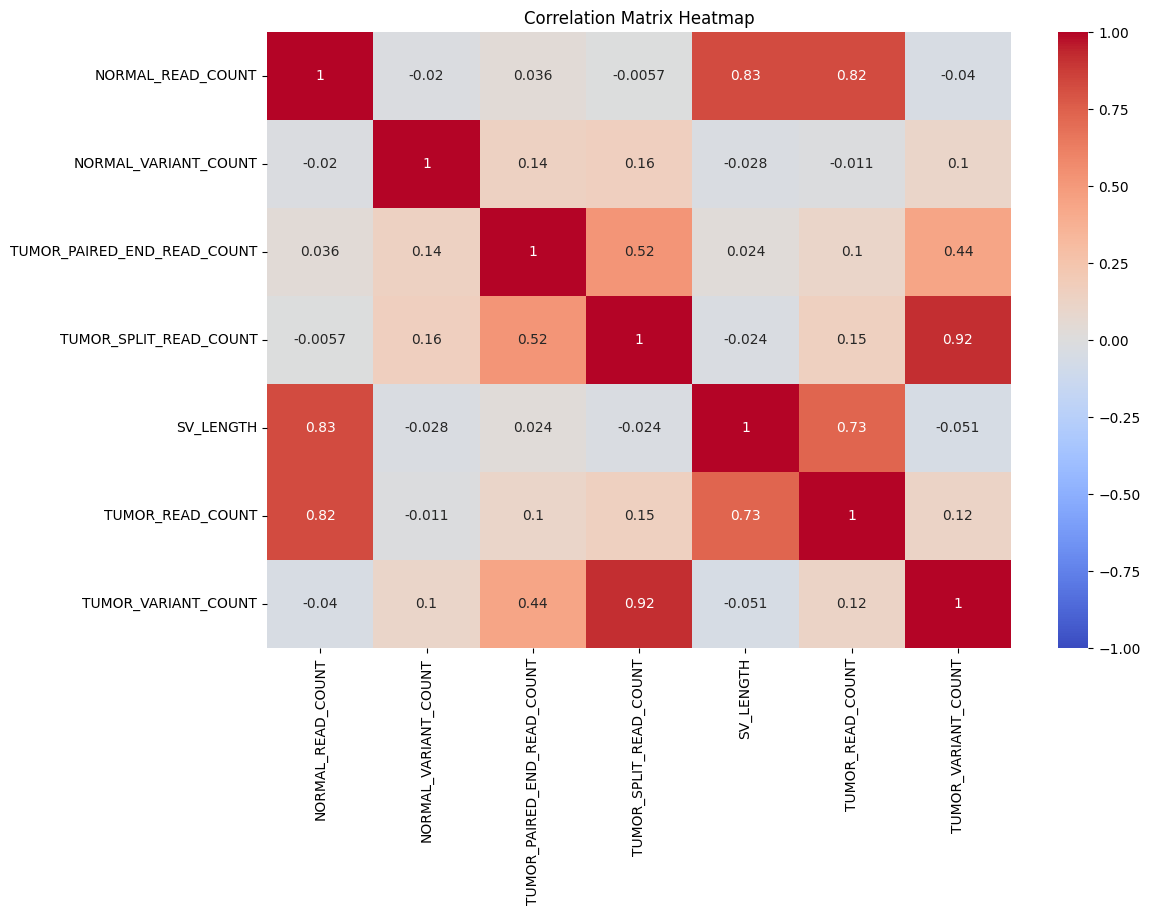

In [22]:
# Compute the correlation matrix
corr = numeric_cols.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()